# EX 2-1 ANN MNIST implemented by PyTorch
여러명이 같이 개발을 하거나 이전의 코드를 재활용 해야하는 상황등 많은 경우에는 여러개의 딥러닝 라이브러리를 사용해야 하는 경우가 생긴다. 이런 경우에 대비해 케라스를 기본으로 활용하는 텐서플로 2.0 (소위, '케라스 텐서플로2') 코드를 파이토치로 바꾸는 사례를 포함한다.

## I. Jupyter를 위한 코드

In [1]:
# %load /home/sjkim/.jupyter/head.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

# seaborn
#import seaborn as sns
#sns.set( style = 'white', font_scale = 1.7)
#sns.set_style('ticks')
#plt.rcParams['savefig.dpi'] = 200

# font for matplotlib
#import matplotlib
#import matplotlib.font_manager as fm
#fm.get_fontconfig_fonts()
#font_location = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
#font_name = fm.FontProperties(fname=font_location).get_name()
#matplotlib.rc('font', family=font_name)

## II. 공통 라이브러리
다음은 이 코드에서 사용하는 공통 라이브러리들이다. 

### 결과 그래프를 출력하는 공통 라이브러리 함수들이다

In [2]:
##############################################
# Plotting
##############################################
import matplotlib.pyplot as plt


def plot_acc(history, title=None):
    # summarize history for accuracy
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    if title is not None:
        plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Verification'], loc=0)
    # plt.show()


def plot_loss(history, title=None):
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Verification'], loc=0)
    # plt.show()

### 케라스를 기본으로 활용하는 텐서플로 2.0 (소위, '케라스 텐서플로2')를 위한 라이브러리
텐서플로 2.0부터는 케라스를 텐서플로와 통합해서 사용할 수 있다. 이 경우에 이전 (순수) 케라스 코드와 호환을 하기 위해 공통 코드를 작성한다.

In [9]:
class History:
    def __init__(self):
        self.history = {'accuracy': [], 'loss': [], 'val_accuracy': [], 'val_loss': []}   

### 케라스와 호완을 위한 파이토치용 라이브러리를 만든다.
파이토치 구현한 코드가 케라스로 구현한 코드와 호환성을 높이기 위해 라이브러리 코드를 만든다.

In [10]:
class Metrics_Mean:
    def __init__(self): self.reset_states()
    def __call__(self, loss): self.buff.append(loss.data)
    def reset_states(self): self.buff = []
    def result(self): return np.mean(self.buff)

class Metrics_CategoricalAccuracy:
    def __init__(self): 
        self.reset_states()
    def __call__(self, labels, predictions): 
        decisions = predictions.data.max(1)[1]
        self.correct += decisions.eq(labels.data).cpu().sum()
        self.L += len(labels.data)
    def reset_states(self): 
        self.correct, self.L = 0, 0
    def result(self): return float(self.correct) / self.L

## III. PyTorch Implementation
- Reference: https://github.com/CSCfi/machine-learning-scripts/blob/master/notebooks/pytorch-mnist-mlp.ipynb

이번에는 케라스가 기본으로 내장된 Tensorflow 2.0을 이용해 작성한 코드를 PyTorch로 바꾸어 보았다.

### 먼저, 파이토치 방식으로 딥러닝 모델을 만든다.
모델을 만들기 위해 torch, torch.nn 그리고 torch.nn.functional을 임포트한다. 

그리고 모델링을 위한 클래스를 만들 때는 nn.Module을 상속한다. Dense 계층을 만들기 위해서는 nn.Linear()를 활용한다. 케라스의 Dense()와 차이는 각 계층의 입력과 출력의 노드 수를 모두 적어야 한다는 점이다. 케라스는 출력만 적고 입력의 길이는 이전 계층에서 자동으로 계산하여 가져온다. **케라스의 모델링 방식은 입력을 줄여서 편하지만 파이토치의 방식에 비해 가독성을 약간 떨어뜨린다는 말도 있다**. 파이토치에서는 출력을 계산하는 함수명은 call() 대신에 forward()를 사용한다. rulu와 softmax는 torch.nn.functional 즉 F에서 가져온다. 이렇게 바꾸고 보면 용어만 일부틀리고 케라스와 상당히 유사한 형태로 구성이 가능함을 알 수 있다. 

In [11]:
##############################################
# Modeling
##############################################
import torch 
from torch import nn
import torch.nn.functional as F
      
class ANN_models_class(nn.Module):
    def __init__(self, Nin, Nh, Nout):
        super().__init__()
        self.hidden = nn.Linear(Nin, Nh)
        self.last = nn.Linear(Nh, Nout)        
        self.Nin = Nin
        
    def forward(self, x):  
        x = x.view(-1, self.Nin)
        h = F.relu(self.hidden(x))
        y = F.softmax(self.last(h), dim=1)
        return y 
    
# model = ANN_models_class(784, 100, 10)

### 이제 데이터를 불러오자.
데이터를 부르기 위해서 torchvision 아래에 있는 datasets와 transforms을 임포트한다. train_ds와 test_ds는 자동으로 배치 데이터를 생성해주는 이트레이터이다. 그래서 데이터를 직접 제공하는 대신 이 Data)func() 함수에서는 두 이터레이터를 생성해서 반납한다. 

In [12]:
##############################################
# Data
##############################################
from torchvision import datasets, transforms
batch_size = 100

def Data_func():

    train_dataset = datasets.MNIST('~/pytorch_data', 
        train=True, download=True, transform=transforms.ToTensor())
    test_dataset = datasets.MNIST('~/pytorch_data', 
        train=False, transform=transforms.ToTensor())

    train_ds = torch.utils.data.DataLoader(dataset=train_dataset, 
        batch_size=batch_size, shuffle=True)
    test_ds = torch.utils.data.DataLoader(dataset=test_dataset, 
        batch_size=batch_size, shuffle=False)
    
    return train_ds, test_ds

train_ds, test_ds = Data_func()

### 주 인공지능 코드 부분을 작성한다.
텐서플로 2.0에서는 tf2.GradientTape()를 활용해 학습에 필요한 미분값(gradients)을 구하지만 파이토치에서는 Optimizer.zero_grad()만으로 학습을 시작할 수 있다. 변수가 미분이 가능한 모드로 되어 있을 경우, loss.backward() 함수를 통해 자동으로 미분값을 구할 수 있게 되어 있기 때문이다. 그리고 미분한 결과로 가중치들과 바이어스값들을 업데이트할 때 대상을 명시할 필요가 없다. 이미 Optimizer를 정의할 때 업데이트 할 파라메터인 model.parameters()를 명시했기 때문이다. 

Epoch 1, Loss: 1.63, Accuracy: 83.36%, Test Loss: 1.59, Test Accuracy: 86.80%
Epoch 2, Loss: 1.56, Accuracy: 89.94%, Test Loss: 1.52, Test Accuracy: 94.16%
Epoch 3, Loss: 1.52, Accuracy: 94.43%, Test Loss: 1.52, Test Accuracy: 94.52%
Epoch 4, Loss: 1.51, Accuracy: 94.97%, Test Loss: 1.51, Test Accuracy: 95.21%
Epoch 5, Loss: 1.51, Accuracy: 95.36%, Test Loss: 1.50, Test Accuracy: 95.65%


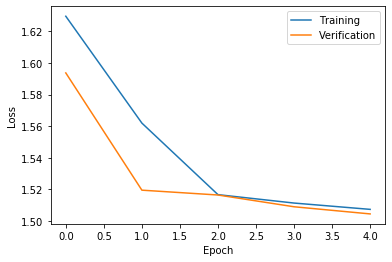

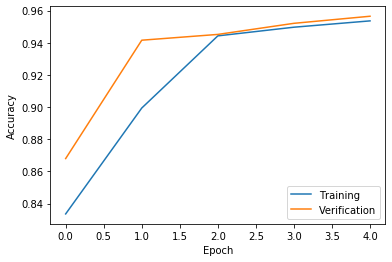

In [6]:
##############################################
# Main
##############################################
Nin = 784
Nh = 100
number_of_class = 10
Nout = number_of_class

model = ANN_models_class(Nin, Nh, Nout)
# model.build(input_shape=[None,Nin])

train_ds, test_ds = Data_func()

train_loss = Metrics_Mean()
train_accuracy = Metrics_CategoricalAccuracy()
test_loss = Metrics_Mean()
test_accuracy = Metrics_CategoricalAccuracy()
    
history = History()

Optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
Loss_object = torch.nn.CrossEntropyLoss()
for epoch in range(5):
    for images, labels in train_ds:
        Optimizer.zero_grad()
        predictions = model(images)
        loss = Loss_object(predictions, labels)
        loss.backward()
        Optimizer.step()
        train_loss(loss)
        train_accuracy(labels, predictions)

    for images, labels in test_ds:
        predictions = model(images)
        t_loss = Loss_object(predictions, labels)
        test_loss(t_loss)
        test_accuracy(labels, predictions)
        
    history.history['accuracy'].append(train_accuracy.result())
    history.history['loss'].append(train_loss.result())
    history.history['val_accuracy'].append(test_accuracy.result())
    history.history['val_loss'].append(test_loss.result())
    
    template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%, Test Loss: {:.2f}, Test Accuracy: {:.2f}%'
    print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
############################################
# Training
##############################################
plot_loss(history)
plt.show()
plot_acc(history)
plt.show()